In [2]:
from matplotlib import gridspec, cm
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
import pickle
import skimage.io
import yellowbrick
from skimage.feature import hog
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, OPTICS, SpectralClustering, AgglomerativeClustering, FeatureAgglomeration, Birch, AffinityPropagation, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA,KernelPCA, SparsePCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
from PIL import Image
from fcmeans import FCM

import statsmodels.api as sm
from scipy.stats import shapiro, kstest, normaltest, anderson
import sys
sys.path.insert(0,'../')
import label_tools as lt

#### Load data

In [2]:
# archive
#fc1_path = Path('/home/richard/data/Schiefer/features/VGG16_fc1_feature_std.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/features/VGG16_fc1_feature_std_224.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/features/ResNet152_feature_std.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/features/ResNet152_feature_std_224.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/features/ResNet152_feature_std_224_normalized.pickle') # OG!
# fc1_path = Path('/home/richard/data/Schiefer/tests/features/ResNet152_polygon_gt.pickle') # gt bad
#fc1_path = Path('/home/richard/data/Schiefer/tests/features/ResNet152_squares_pred.pickle') # og corrected squares
#fc1_path = Path('/home/richard/data/Schiefer/features/ResNet152_feature_std_squares_224_normalized.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/tests/features/ResNet152_feature_std_squares_224_normalized.pickle') # SQUARES 224, good results
#fc1_path = Path('/home/richard/data/Schiefer/features/ResNet152_feature_std_448_normalized.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/features/ResNet152_feature_std_224_non_normalized.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/features/Inception_v3_feature_std_224_normalized.pickle') # also good
#fc1_path = Path('/home/richard/data/Schiefer/features/MobileNet_v3_feature_std_224_normalized.pickle')

#fc1_path = Path('/home/richard/data/Schiefer/tests/features/ResNet152_polygon_pred.pickle') # og corrected
#fc1_path = Path('/home/richard/data/Schiefer/features/concat_polygon_pred.pickle') # og corrected

In [3]:
# fc1_path = Path('/home/richard/data/Schiefer/feature_extraction/features/ResNet152_gt_polygon_cfb184_296.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/feature_extraction/features/ResNet152_gt_square_cfb184_285.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/feature_extraction/features/ResNet152_pred_polygon_cfb184_224.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/feature_extraction/features/ResNet152_pred_square_cfb184_205.pickle')

fc1_path = Path('/home/richard/data/Schiefer/combine/ResNet152_polygon_pred_1126.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/combine/ResNet152_square_pred_1140.pickle')
assert fc1_path.is_file()
# TODO: change name scheme of file in step 3

#le_path = Path('/home/richard/data/Schiefer/feature_extraction/labels/ResNet152_gt_polygon_label_encodings_cfb184_296.pickle')
#le_path = Path('/home/richard/data/Schiefer/feature_extraction/labels/ResNet152_gt_square_label_encodings_cfb184_285.pickle')
#le_path = Path('/home/richard/data/Schiefer/feature_extraction/labels/ResNet152_pred_polygon_label_encodings_cfb184_224.pickle')
#le_path = Path('/home/richard/data/Schiefer/feature_extraction/labels/ResNet152_pred_square_label_encodings_cfb184_205.pickle')

le_path = Path('/home/richard/data/Schiefer/combine/ResNet152_polygon_pred_label_encodings_1126.pickle')
#le_path = Path('/home/richard/data/Schiefer/combine/ResNet152_square_pred_label_encodings_1140.pickle')
assert le_path.is_file()

# load the data and label encoder into memory
with open(fc1_path, 'rb') as f:
    data = pickle.load(f)
    
with open(le_path, 'rb') as l:
    le = pickle.load(l)

In [4]:
files = data['filename']
fc1 = data['features']
labels = data['labels']
y_gt = le.transform(labels)
# print(labels)
# print(y_gt)

In [5]:
print(set(y_gt))
print(set(labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8}
{'Pinus_sylvestris', 'Fagus_sylvatica', 'Larix_decidua', 'Fraxinus_excelsior', 'deadwood', 'Quercus_spec', 'Abies_alba', 'Pseudotsuga_menziesii', 'Picea_abies'}


In [6]:
print(type(fc1[0]))
print(fc1.shape)

<class 'numpy.ndarray'>
(1126, 2048)


#### Dimension reduction
#### PCA

- PCA reduce dimensionality and filter out noise in the data
- How many dimensions to keep?
- No clear answer, but keep components that contain **signal** (significant variance) and **get rid of ones** that are mostly noise
  - A: rule of thumb for high dimensional data is to select 50 components
  - inspect how much variance each component preserves before selecting 50
  - B: or directly aim for an automated process to determine the amount of components

#### Simple PCA

#### A

variance preserved by 50 components: 0.525


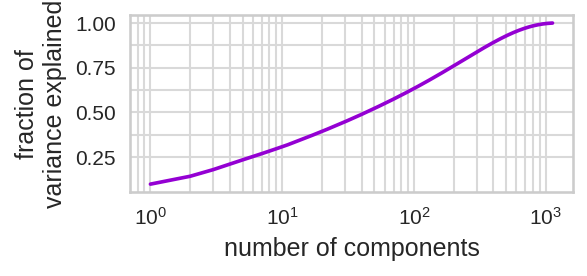

In [7]:
scaler = StandardScaler().set_output()
rescaled = scaler.fit_transform(fc1)
pca_n = PCA(svd_solver='full')
x_pca_ = pca_n.fit_transform(rescaled) # apply reduction on x

var_ = pca_n.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots(figsize=(4,2),dpi=150,)
ax.grid('on', which='both', color=np.ones(3)*0.85)
ax.plot(range(1,len(var_)+1), var_, color='darkviolet')
ax.set_xscale('log')
ax.set_xlabel('number of components')
ax.set_ylabel('fraction of\nvariance explained')

yt=np.linspace(1/4, 1, 4)
ytm = [np.mean([yt[i], yt[i+1]]) for i in range(len(yt)-1)]
ax.set_yticks(ytm, minor=True)

fig.tight_layout()
#fig.savefig(Path('..','Figures','PCA_Var.png'), bbox_inches='tight')
print('variance preserved by 50 components: {:.3f}'.format(var_[50]))


0.6484472


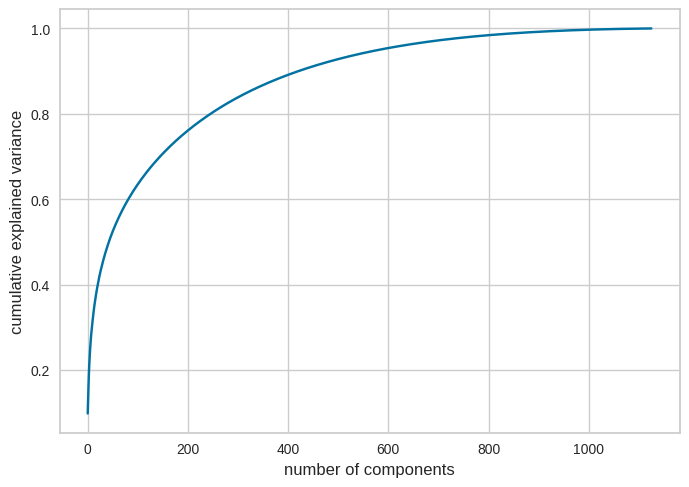

In [8]:
scaler = StandardScaler().set_output()
rescaled = scaler.fit_transform(fc1)
pca = PCA().fit(rescaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
print()
var_ = pca.explained_variance_ratio_.cumsum()
print(var_[108])

#### B Min-Max [0,1] Scaler

In [9]:
# # select pca data and determine number of components in an automatic fashion
# scaler = MinMaxScaler()
# data_rescaled = scaler.fit_transform(fc1) # scale data to the range between 0 and 1
# pca = PCA(n_components = 0.95) # wand explained variace between 95-99%
# pca.fit(data_rescaled)
# reduced = pca.fit_transform(data_rescaled)
# print(reduced.shape)

#### B1 z Score Scaler

In [10]:
# # standardize values with z-score more effective than min-max and decimal scaling!
# # removing mean and scaling to unit variance
# # mean of 0 and standard deviation of 1, unlike min-max it does not rescale the feature to a fixed range
# rescaled = StandardScaler().fit_transform(fc1) # can be transformed to pandas df
# #reduced = rescaled

# # normal pca
# #scaled_pca = PCA(n_components=0.90, svd_solver='full', random_state=42, whiten=False) # higher values may introduce overfitting of the model, rs only for different svd solver relevant
# scaled_pca = PCA(n_components=0.80, svd_solver='full', random_state=42, whiten=False)
# scaled_pca.fit(rescaled)
# reduced = scaled_pca.fit_transform(rescaled)
# print(reduced.shape)

# plt.scatter(
#     reduced[:, 0],
#     reduced[:, 1])
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('PCA plot', fontsize=24)

(1126, 33)


Text(0.5, 1.0, 'PCA plot')

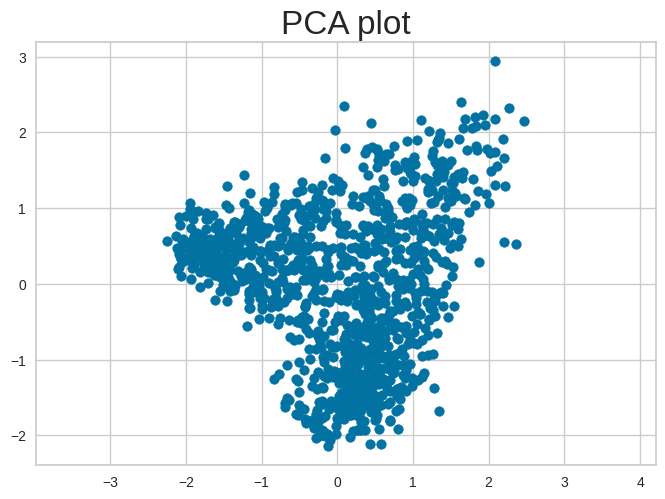

In [11]:
# basic pca on raw not standardized data
pca = PCA(n_components=0.80, svd_solver='full', random_state=42, whiten=True) # higher values may introduce overfitting of the model, rs only for different svd solver relevant, 50 is arbitrary choice
pca.fit(fc1)
reduced = pca.fit_transform(fc1)
print(reduced.shape)

plt.scatter(
    reduced[:, 0],
    reduced[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA plot', fontsize=24)

#### UMAP

In [12]:
# import umap # non linear transformation (compared to pca)
# reducer = umap.UMAP(random_state=666)
# scaler = StandardScaler().set_output() # can be transformed to pandas df
# rescaled = scaler.fit_transform(fc1)
# reduced = reducer.fit_transform(rescaled)
# print(reduced.shape)

# plt.scatter(
#     reduced[:, 0],
#     reduced[:, 1])
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection Schiefer', fontsize=24)

In [13]:
# import umap # non linear transformation (compared to pca)
# reducer = umap.UMAP(random_state=666)
# reduced = reducer.fit_transform(fc1)
# print(reduced.shape)

# plt.scatter(
#     reduced[:, 0],
#     reduced[:, 1])
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection Schiefer', fontsize=24)

In [14]:
# percentile method
# print("percent of arr", np.percentile(reduced[:,0], [25,50,75]))
# print("percent of arr", np.percentile(reduced, [25,50,75] , axis = 0))

#### Kernel PCA

In [15]:
# scaler = MinMaxScaler()
# data_rescaled = scaler.fit_transform(fc1) # scale data to the range between 0 and 1
# pca = PCA(n_components = 0.95) # wand explained variace between 95-99%
# kernel_pca = KernelPCA(
#     n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
# )

# X_test_kernel_pca = kernel_pca.fit(data_rescaled).fit_transform(data_rescaled)
# print(X_test_kernel_pca.shape)
# reduced = X_test_kernel_pca

#### Sparse PCA

In [16]:
# scaler = StandardScaler().set_output(transform="pandas")
# rescaled = scaler.fit_transform(fc1)

# sparse_PCA = SparsePCA(n_components=100, random_state=25)
# sparse_PCA.fit(rescaled)
# reduced = sparse_PCA.fit_transform(rescaled)
# print(reduced.shape)

#### Randomized PCA

In [17]:
# scaler = StandardScaler().set_output(transform="pandas")
# rescaled = scaler.fit_transform(fc1)
# #reduced = rescaled

# scaled_pca = PCA(n_components=108, svd_solver='randomized', random_state=27) # higher values may introduce overfitting of the model
# scaled_pca.fit(rescaled)
# reduced = scaled_pca.fit_transform(rescaled)
# print(reduced.shape)

#### Feature Agglomeration

In [18]:
# scaler = StandardScaler().set_output(transform="pandas")
# rescaled = scaler.fit_transform(fc1)

# agglo = FeatureAgglomeration(n_clusters=5)
# agglo.fit(rescaled)
# reduced = agglo.transform(rescaled)
# print(reduced.shape)

#### Determine the optimal number of clusters k

#### A: Elbow Method

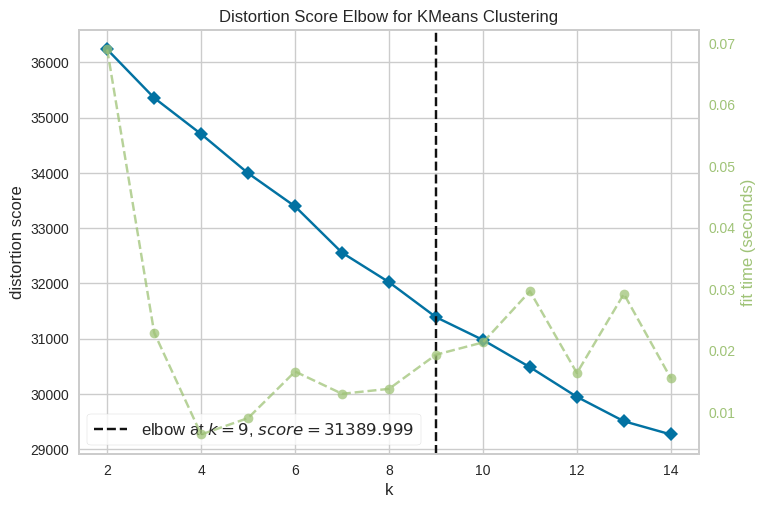

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
from yellowbrick.cluster import KElbowVisualizer
kmean_model = KMeans(init='k-means++', n_init='auto', random_state=42)
visualizer = KElbowVisualizer(kmean_model, k=(2,15), timings= True)
visualizer.fit(reduced)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

#### B: Scaled Insertia Method

In [20]:
# # scaled inertia approach to determine optimal k
# def kMeansRes(scaled_data, k, alpha_k=0.02):
#     '''
#     Parameters 
#     ----------
#     scaled_data: matrix 
#         scaled data. rows are samples and columns are features for clustering
#     k: int
#         current k for applying KMeans
#     alpha_k: float
#         manually tuned factor that gives penalty to the number of clusters
#     Returns 
#     -------
#     scaled_inertia: float
#         scaled inertia value for current k           
#     '''
    
#     inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
#     # fit k-means
#     kmeans = KMeans(n_init='auto',init='k-means++', n_clusters=k, random_state=0).fit(scaled_data)
#     scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
#     return scaled_inertia

# def chooseBestKforKMeansParallel(scaled_data, k_range):
#     '''
#     Parameters 
#     ----------
#     scaled_data: matrix 
#         scaled data. rows are samples and columns are features for clustering
#     k_range: list of integers
#         k range for applying KMeans
#     Returns 
#     -------
#     best_k: int
#         chosen value of k out of the given k range.
#         chosen k is k with the minimum scaled inertia value.
#     results: pandas DataFrame
#         adjusted inertia value for each k in k_range
#     '''
    
#     ans = Parallel(n_jobs=-1,verbose=10)(delayed(kMeansRes)(scaled_data, k) for k in k_range)
#     ans = list(zip(k_range,ans))
#     results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
#     best_k = results.idxmin()[0]
#     return best_k, results

# def chooseBestKforKMeans(scaled_data, k_range):
#     ans = []
#     for k in k_range:
#         scaled_inertia = kMeansRes(scaled_data, k)
#         ans.append((k, scaled_inertia))
#     results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
#     best_k = results.idxmin()[0]
#     return best_k, results

# # choose k range
# k_range=range(2,20)
# # compute adjusted intertia
# best_k, results = chooseBestKforKMeansParallel(reduced, k_range)
# print("best k is",best_k)

# # plot the results
# plt.figure(figsize=(7,4))
# plt.plot(results,'o')
# plt.title('Adjusted Inertia for each K')
# plt.xlabel('K')
# plt.ylabel('Adjusted Inertia')
# plt.xticks(range(2,20,1))

#### C: Gap Statistics

In [21]:
# def optimalK(data, nrefs=3, maxClusters=15):
#     """
#     Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
#     Params:
#         data: ndarry of shape (n_samples, n_features)
#         nrefs: number of sample reference datasets to create
#         maxClusters: Maximum number of clusters to test for
#     Returns: (gaps, optimalK)
#     """
#     gaps = np.zeros((len(range(1, maxClusters)),))
#     resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
#     for gap_index, k in enumerate(range(1, maxClusters)):
#         # Holder for reference dispersion results
#         refDisps = np.zeros(nrefs)
#         # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
#         for i in range(nrefs):
            
#             # Create new random reference set
#             randomReference = np.random.random_sample(size=data.shape)
            
#             # Fit to it
#             km = KMeans(k, n_init='auto')
#             km.fit(randomReference)
            
#             refDisp = km.inertia_
#             refDisps[i] = refDisp
#         # Fit cluster to original data and create dispersion
#         km = KMeans(k, n_init='auto')
#         km.fit(data)
        
#         origDisp = km.inertia_
#         # Calculate gap statistic
#         gap = np.log(np.mean(refDisps)) - np.log(origDisp)
#         # Assign this loop's gap statistic to gaps
#         gaps[gap_index] = gap
        
#         resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
#     return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

# # Automatically output the number of clusters
# k, gapdf = optimalK(reduced, nrefs=3, maxClusters=15)
# print('Optimal k is: ', k)
# # Visualization
# plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
# plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
# plt.grid(True)
# plt.xlabel('Cluster Count')
# plt.ylabel('Gap Value')
# plt.title('Gap Values by Cluster Count')
# plt.show()

#### D: Silhouette score for k-means

In [22]:
# model = KMeans(init='k-means++', n_init='auto', random_state=42)
# # k is range of number of clusters.
# visualizer = KElbowVisualizer(model, k=(2,15),metric='silhouette', timings= True)
# visualizer.fit(reduced)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

#### E: Calinksi Harabasz Score for k-means

In [23]:
# model = KMeans(init='k-means++', n_init='auto', random_state=42)
# # k is range of number of clusters.
# visualizer = KElbowVisualizer(model, k=(2,15),metric='calinski_harabasz', timings= True)
# visualizer.fit(reduced)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

#### F: Dendogram hierarchical clustering

In [24]:
# # Dendogram for Heirarchical Clustering
# import scipy.cluster.hierarchy as shc
# plt.figure(figsize=(10, 7))  
# plt.title("Dendrograms")  
# dend = shc.dendrogram(shc.linkage(reduced, method='ward'))

### t-sne/pca visulization on data

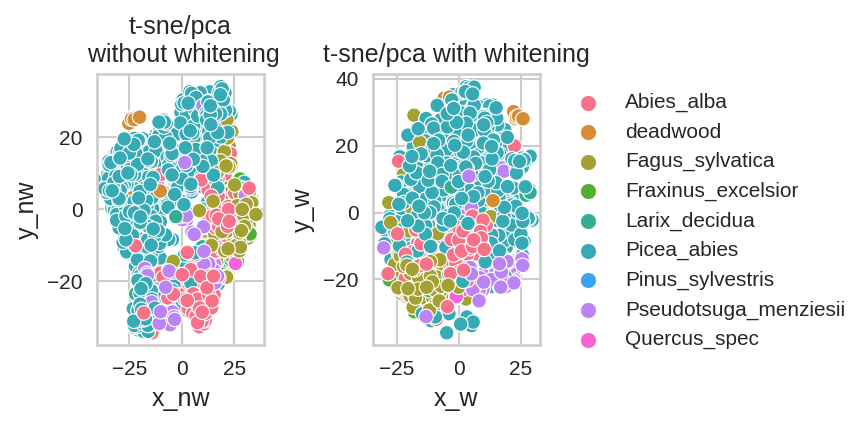

In [25]:
# no whitening
pca_nw = PCA(n_components=50, svd_solver='full', whiten=False, random_state=42)
x_nw = pca_nw.fit_transform(fc1)
tsne = TSNE(n_components=2, random_state=12214)
x_nw_tsne = tsne.fit_transform(x_nw)
#with withening
pca = PCA(n_components=50, svd_solver='full', whiten=True, random_state=42)
x = pca.fit_transform(fc1)
tsne_w = TSNE(n_components=2, random_state=654753)
x_w_tsne = tsne_w.fit_transform(x)

labels_ordered = le.inverse_transform(range(len(le.mapper)))
df = pd.DataFrame({'files': files,
                   'x_nw':x_nw_tsne[:,0],
                   'y_nw':x_nw_tsne[:,1],
                   'x_w': x_w_tsne[:,0],
                  'y_w': x_w_tsne[:,1],
                   'labels': labels,
                  },
                  index=files)

fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=150)
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered,  ax=ax[0])
sns.scatterplot(data=df, x='x_w', y='y_w', hue='labels', hue_order=labels_ordered, ax=ax[1])
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('t-sne/pca\n without whitening')
ax[1].set_title('t-sne/pca with whitening')
fig.tight_layout()
plt.show()

#### Pano plot

In [10]:
pca_nw = PCA(n_components=50, svd_solver='full', whiten=False, random_state=42)
x_nw = pca_nw.fit_transform(fc1)
X = np.array(x_nw)
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, n_iter=3000, random_state=567).fit_transform(X)

tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

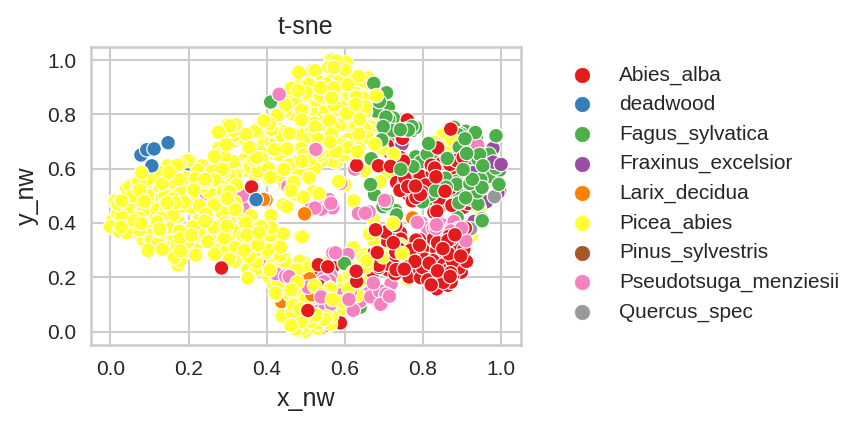

In [20]:
labels_ordered = le.inverse_transform(range(len(le.mapper)))
df = pd.DataFrame({'files': files,
                   'x_nw':tx,
                   'y_nw':ty,
                   'labels': labels,
                  },
                  index=files)

fig, ax = plt.subplots(1,1,figsize=(6,3), dpi=150)
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', palette='Set1', hue_order=labels_ordered)
ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1.05,1))
ax.set_title('t-sne')
fig.tight_layout()
plt.show()

/tmp/ipykernel_263547/2266761669.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)


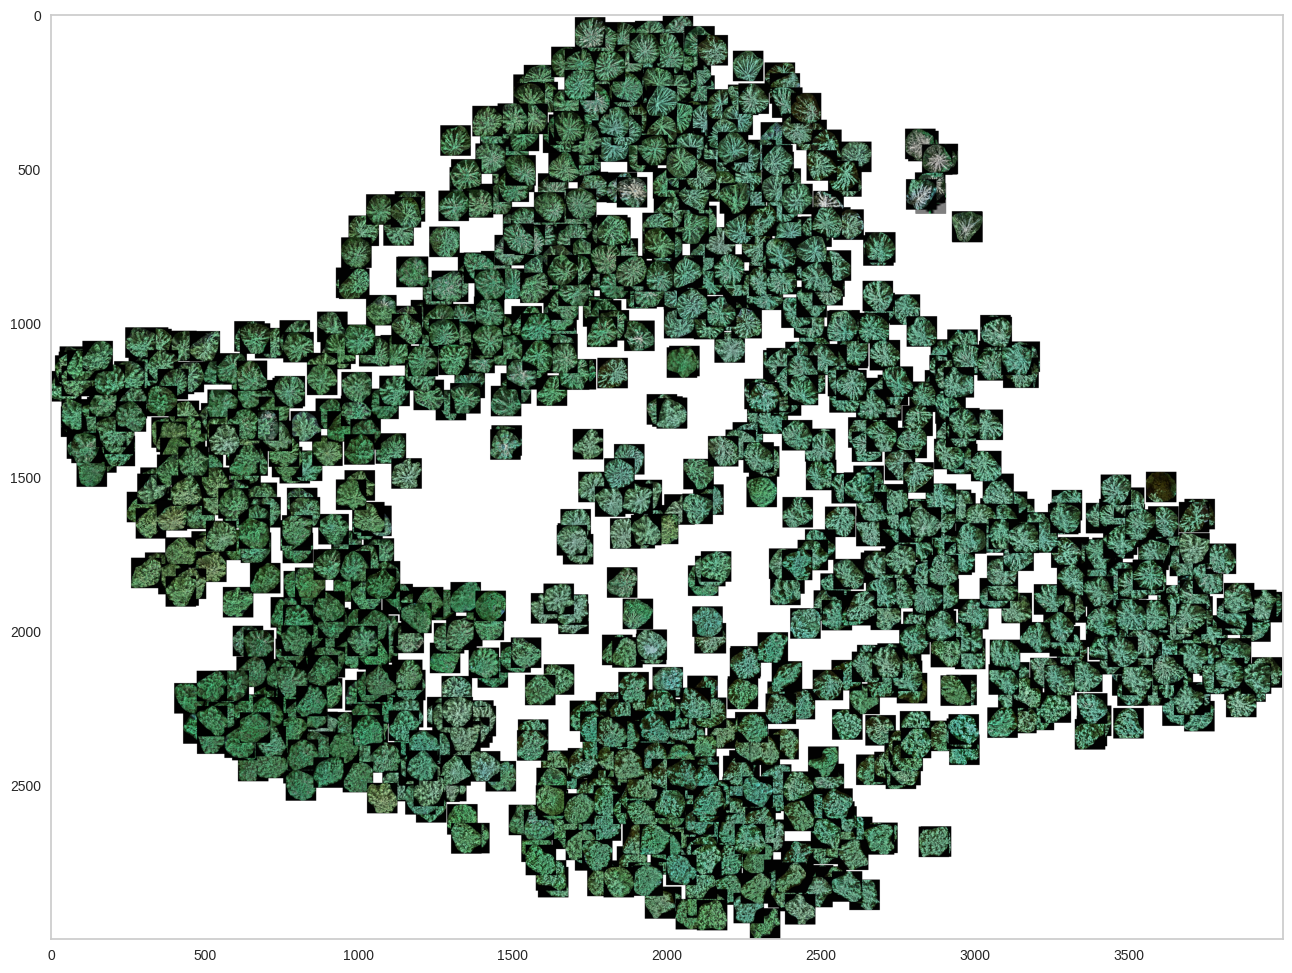

In [9]:
import matplotlib.pyplot
from matplotlib.pyplot import imshow

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(files, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)
plt.grid(None)
#plt.savefig('/home/richard/Pictures/temp/tsne_img.pdf')

In [29]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import cv2
def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()
images_path = '/home/richard/data/Schiefer/tests/preprocessed_withpixel_polygon_pred224/'
image_files = glob.glob(images_path + '*.png')
image_files.sort()
images = []
for i in image_files:
    image = cv2.imread(i)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (100,100))
    #image = image.flatten()
    images.append(image)
images = np.array(images)

In [30]:

#visualize_scatter_with_images(x_nw_tsne, images = [np.reshape(i, (100,100,3)) for i in images], image_zoom=0.7)

In [31]:
# labels_ordered = le.inverse_transform(range(len(le.mapper)))
# df = pd.DataFrame({'files': files,
#                    'x_nw':x_nw_tsne[:,0],
#                    'y_nw':x_nw_tsne[:,1],
#                    'labels': labels,
#                   },
#                   index=files)

# fig, ax = plt.subplots(1, figsize=(6,3), dpi=150)
# sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered)
# ax.legend(bbox_to_anchor=(1.05,1))
# ax.set_title('t-sne/pca\n without whitening')
# fig.tight_layout()
# plt.show()

#### Applying MeanShift

In [32]:
bandwidth = estimate_bandwidth(reduced, quantile=0.3, n_samples=224, random_state=444)

model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
model.fit(reduced)
labels_unmatched = model.labels_
print(labels_unmatched)
y_pred = lt.label_matcher(labels_unmatched, y_gt)

cluster_centers = model.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)
print(set(labels_unmatched))
print(set(y_pred))

[0 0 0 ... 0 0 0]
number of estimated clusters : 9
{0}
{5}


#### Applying K-Means

In [33]:
# # alt clustering
# # # initialize model
# model = KMeans(n_clusters=9, init='k-means++', n_init=500, random_state=42)
# #fit data into the model
# model.fit(reduced)
# # extract labels
# labels_unmatched = model.labels_
# print(set(labels_unmatched))
# print(labels_unmatched)
# y_pred = lt.label_matcher(labels_unmatched, y_gt)
# print(set(y_pred))
# print(y_pred)
# print('inertia: {:.2f}'.format(model.inertia_))
# print(f"Silhouette Coefficient: {silhouette_score(reduced, labels_unmatched):.3f}") # if gt not known
# print("Calinksi-Harabasz index:", calinski_harabasz_score(reduced, labels_unmatched))
# print("Davies-Bouldin index:", davies_bouldin_score(reduced, labels_unmatched))

#### Applying K-medoids

In [34]:
# kmedoids = KMedoids(n_clusters=9, random_state=42)
# kmedoids.fit(reduced)
# labels_unmatched = kmedoids.labels_
# print(labels_unmatched)
# y_pred = lt.label_matcher(labels_unmatched, y_gt)
# print(set(y_pred))
# print('inertia: {:.2f}'.format(kmedoids.inertia_))
# # application after PCA better accuracy than only rescaled data

#### Fuzzy K-means

In [35]:
# model = FCM(n_clusters = 9)
# model.fit(reduced)

# centers = model.centers
# labels_unmatched = model.predict(reduced)
# print(labels_unmatched)
# y_pred = lt.label_matcher(labels_unmatched, y_gt)
# print(y_pred)
# print(set(labels_unmatched))
# print(set(y_pred))

#### Agglomerative Clustering (hierarchical)

In [36]:
# clustering = AgglomerativeClustering(n_clusters=9).fit(reduced)
# labels_unmatched = clustering.labels_
# y_pred = lt.label_matcher(labels_unmatched, y_gt)
# print(set(labels_unmatched))
# print(set(y_pred))

#### Applying DBSCAN

In [37]:
# # very sensitive to parameters
# from sklearn import metrics

# print(rescaled.shape)
# print(reduced.shape)
# dbscan = DBSCAN(eps=60, min_samples=150).fit(reduced)
# labels_unmatched = dbscan.labels_
# labels_true = y_gt
# print(labels_unmatched)

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels_unmatched)) - (1 if -1 in labels_unmatched else 0)
# n_noise_ = list(labels_unmatched).count(-1)

# print("Estimated number of clusters: %d" % n_clusters_)
# print("Estimated number of noise points: %d" % n_noise_)

# print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels_unmatched):.3f}")
# print(f"Completeness: {metrics.completeness_score(labels_true, labels_unmatched):.3f}")
# print(f"V-measure: {metrics.v_measure_score(labels_true, labels_unmatched):.3f}")
# print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels_unmatched):.3f}")
# print(
#     "Adjusted Mutual Information:"
#     f" {metrics.adjusted_mutual_info_score(labels_true, labels_unmatched):.3f}"
# )
# print(f"Silhouette Coefficient: {metrics.silhouette_score(reduced, labels_unmatched):.3f}")

# y_pred = label_matcher(labels_unmatched, y_gt)

# unique_labels = set(labels_unmatched)
# core_samples_mask = np.zeros_like(labels_unmatched, dtype=bool)
# core_samples_mask[dbscan.core_sample_indices_] = True

# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = labels == k

#     xy = reduced[class_member_mask & core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=14,
#     )

#     xy = reduced[class_member_mask & ~core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=6,
#     )

# plt.title(f"Estimated number of clusters: {n_clusters_}")
# plt.show()

#### HDBSCAN

In [38]:
# import hdbscan

# clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True, gen_min_span_tree=False, leaf_size=40, metric='euclidean', min_cluster_size=8, min_samples=None, p=None)
# clusterer.fit(reduced)
# print(clusterer.labels_)
# print(clusterer.labels_.max())

# labels_unmatched = clusterer.labels_
# y_pred = lt.label_matcher(labels_unmatched, y_gt)

#### Optics (better suited on large datasets)

In [39]:
# clustering = OPTICS(min_samples=9).fit(rescaled)
# labels_unmatched = clustering.labels_
# print(labels_unmatched)

#### Spectral Clustering

In [40]:
# clustering = SpectralClustering(n_clusters=5, assign_labels='discretize', random_state=42).fit(reduced)
# labels_unmatched = clustering.labels_
# y_pred = label_matcher(labels_unmatched, y_gt)
# print(labels_unmatched)

#### BIRCH algorithm

In [41]:
birch = Birch(threshold=0.5, n_clusters=9).fit(reduced)
labels_unmatched = birch.labels_
y_pred = lt.label_matcher(labels_unmatched, y_gt)
print(labels_unmatched)
print(set(labels_unmatched))
print(set(y_pred))

[7 1 7 ... 1 0 0]
{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 5}


#### Affinity Propagation

In [42]:
# ap = AffinityPropagation(preference=-11000, random_state=14).fit(rescaled)
# cluster_centers_indices = ap.cluster_centers_indices_
# labels_unmatched = ap.labels_
# n_clusters_ = len(cluster_centers_indices)
# print(n_clusters_)

# y_pred = label_matcher(labels_unmatched, y_gt)
# print(labels_unmatched)

#### TSNE predictions and ground truth plot

In [43]:
scaler = StandardScaler()
rescaled = scaler.fit_transform(fc1)
# no whitening
pca_nw = PCA(n_components=0.90, svd_solver='full', whiten=False, random_state=42)
x_nw = pca_nw.fit_transform(rescaled)
tsne = TSNE(n_components=2, random_state=12214)
x_nw_tsne = tsne.fit_transform(x_nw)
#with withening
pca = PCA(n_components=0.90, svd_solver='full', whiten=True, random_state=42)
x = pca.fit_transform(rescaled)
tsne_w = TSNE(n_components=2, random_state=654753)
x_w_tsne = tsne_w.fit_transform(x)

labels_ordered = le.inverse_transform(range(len(le.mapper)))
df = pd.DataFrame({'files': files,
                   'x_nw':x_nw_tsne[:,0],
                   'y_nw':x_nw_tsne[:,1],
                   'x_w': x_w_tsne[:,0],
                  'y_w': x_w_tsne[:,1],
                   'labels': labels,
                  },
                  index=files)

y_pred_str = le.inverse_transform(y_pred)
y_gt_str = le.inverse_transform(y_gt)
df['y_pred_labels'] = pd.Series(y_pred_str, index=files)

fig, ax = plt.subplots(1,2, figsize=(8,5), dpi=150)


sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered, ax=ax[0]) # ground truth labels
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='y_pred_labels', hue_order=labels_ordered, ax=ax[1]) # predicted labels

ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('ground truth labels')
ax[1].set_title('predicted labels')
fig.tight_layout()
plt.show()

: 

: 

#### Evaluating Performance (with known truth labels)

In [ ]:
# confusion matrix
# The confusion matrix allows us to evaluate the performance
CM = confusion_matrix(y_gt, y_pred)
lt.pretty_cm(CM, labels_ordered)
print('Accuracy: {:.3f}'.format(CM.trace()/CM.sum()))

In [ ]:
# or just lucky?
# This takes a couple minutes to run, be patient!
use_cache=True
std_10run_cache_path = Path('strunresults.pickle')

if not use_cache or not std_10run_cache_path.is_file():
    rs = np.random.RandomState(seed=987654321)
    accuracies = np.zeros(10)
    for i, seed in enumerate(rs.randint(2**32, size=10)):
        kmeans_ = model = KMeans(n_clusters=4, init='k-means++', n_init=500, random_state=seed)
        kmeans_.fit(reduced)
        labels_unmatched_ = kmeans_.labels_
        y_pred_ = lt.label_matcher(labels_unmatched_, y_gt)
        acc = (y_pred_ == y_gt).sum()/len(y_gt)
        accuracies[i] = acc
    
    with open(std_10run_cache_path, 'wb') as f:
        pickle.dump({'accuracies':accuracies}, f)
else:
    with open(std_10run_cache_path, 'rb') as f:
        results_ = pickle.load(f)
        accuracies = results_['accuracies']

print(accuracies)

In [ ]:
# f1-score
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, rand_score, adjusted_rand_score, mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score
print("F1-score")
print(f1_score(y_gt, y_pred, average='macro'))
print(f1_score(y_gt, y_pred, average='micro'))
print(f1_score(y_gt, y_pred, average='weighted'))
# mean squared error
print("\nMSE")
print(mean_squared_error(y_gt, y_pred))
print(mean_squared_error(y_gt, y_pred, squared=False))
# rand score
print("\nRand index")
print(rand_score(y_gt, y_pred))
print(adjusted_rand_score(y_gt, y_pred))
# mututal information based scores
print("\nMutual information based scores")
print(mutual_info_score(y_gt, y_pred))
print(adjusted_mutual_info_score(y_gt, y_pred))
print(normalized_mutual_info_score(y_gt, y_pred))
# Homogenity, completeness and v-measure
print("\nHomogeneity, completeness and v-measure")
print(homogeneity_score(y_gt, y_pred))
print(completeness_score(y_gt, y_pred))
print(v_measure_score(y_gt, y_pred))
# fowlkes
print("\nFowlkes-mallows-score")
print(fowlkes_mallows_score(y_gt, y_pred))

In [ ]:
# plot all labels

# # normal pca
# scaled_pca = PCA(n_components=2) # higher values may introduce overfitting of the model
# scaled_pca.fit(rescaled)
# reduced = scaled_pca.fit_transform(rescaled)
# print(reduced.shape)

labels_plot = y_pred_str
print(set(labels_plot))
u_labels = np.unique(labels_plot)

for i in u_labels:
    plt.scatter(reduced[labels_plot == i , 0] , reduced[labels_plot == i , 1] , label = i)
plt.legend()
plt.show()

# plot all labels
labels_plot_gt = labels_unmatched
labels_plot_gt = le.inverse_transform(labels_plot_gt)
print(set(labels_plot_gt))
u_labels = np.unique(labels_plot_gt)

for i in u_labels:
    plt.scatter(reduced[labels_plot_gt == i , 0] , reduced[labels_plot_gt == i , 1] , label = i)
plt.legend()
plt.show()

#### Save Predictions

In [ ]:
# make df, optional
df = pd.DataFrame(columns=['filename','label'])
df['filename'] = files
df['label'] = y_pred_str
print(len(df))

df.sort_values(by=['filename'],inplace=True)
with pd.option_context('display.max_colwidth', None):
  display(df.head())
#df.to_csv('/home/richard/data/Schiefer/clustering_results_pred.csv')
# TODO: Include values from clustering alg

#### Visualization of results

In [ ]:
n_row = 8
n_col = 2
_, axs = plt.subplots(n_row, n_col, figsize=(20, 20))
axs = axs.flatten()
imgs = df['filename']
for img_path, ax in zip(imgs[0:n_row*n_col], axs):
    img = Image.open(img_path)
    label_value = df.loc[df.filename == img_path, 'label'].values[0]
    ax.set_title(label_value)
    ax.imshow(img)
plt.tight_layout()
plt.show()
plt.grid(None)

In [ ]:
print(labels_ordered)

In [ ]:
c_number = 0
filtered_labels0 = reduced[labels_plot == c_number]
print(labels_ordered[c_number])
plt.title(labels_ordered[c_number])
plt.scatter(filtered_labels0[:,0] , filtered_labels0[:,1])
plt.show()

In [ ]:
#filter rows of original data
filtered_label2 = reduced[labels_plot == 0]
 
filtered_label8 = reduced[labels_plot == 3]
 
#Plotting the results
plt.title(labels_ordered[0] + "--> red |_| " +  labels_ordered[3] + "--> black")
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'red')
plt.scatter(filtered_label8[:,0] , filtered_label8[:,1] , color = 'black')
plt.show()

In [ ]:
# plot all labels predictions
u_labels = np.unique(labels_plot)
print(u_labels)

for i in u_labels:
    plt.scatter(reduced[labels_plot == i , 0] , reduced[labels_plot == i , 1] , label = i)
plt.legend()
plt.show()


#### T-SNE Visulization

T-SNE maps components in high-dimensional space to lower dimensions. Used to project data to 2d for visulization. Technique preserve pairwise distances for points.

In [ ]:
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(fc1) # scale data to the range between 0 and 1

# tsne
pca_nw = PCA(n_components=0.95, svd_solver='full', whiten=False)
x_nw = pca_nw.fit_transform(data_rescaled)

tsne = TSNE(n_components=2, random_state=12214) # reducing dimension to two
x_nw_tsne = tsne.fit_transform(x_nw)

# scale coordinates to fit 0:1
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = x_nw_tsne[:, 0]
ty = x_nw_tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [ ]:
df = pd.DataFrame({'files': files,
                   'labels': labels,
                  },
                  index=files)

fig, ax = plt.subplots(1, figsize=(6,3), dpi=150)
sns.scatterplot(data=df, x=tx, y=ty, hue='labels')
ax.legend(bbox_to_anchor=(1.05,1))
ax.set_title('t-sne/pca\n without whitening')
fig.tight_layout()
plt.show()

In [ ]:
# # spectral clustering --> bad results
# import sklearn.datasets as skl_data
# import sklearn.cluster as skl_cluster

# graph_model = skl_cluster.SpectralClustering(n_clusters=4, affinity='nearest_neighbors', assign_labels='kmeans')

# scaler = MinMaxScaler()
# gr = scaler.fit_transform(fc1) # scale data to the range between 0 and 1
# pca = PCA(n_components = 0.95) # wand explained variace between 95-99%
# pca.fit(gr)
# graph = pca.fit_transform(gr)

# graph_labels = model.fit_predict(graph)

# plt.scatter(fc1[:, 0], fc1[:, 1], s=15, linewidth=0, c=labels, cmap='flag')
# plt.show()

#### Cluster Analysis

In [ ]:
# scaler = MinMaxScaler()
# Y = scaler.fit_transform(fc1) # scale data to the range between 0 and 1
# pca = PCA(n_components = 0.95) # wand explained variace between 95-99%
# pca.fit(Y)
# X = pca.fit_transform(Y)

# range_n_clusters = [2, 3, 4, 5, 6]

# for n_clusters in range_n_clusters:
#     # Create a subplot with 1 row and 2 columns
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(18, 7)

#     # The 1st subplot is the silhouette plot
#     # The silhouette coefficient can range from -1, 1 but in this example all
#     # lie within [-0.1, 1]
#     ax1.set_xlim([-0.1, 1])
#     # The (n_clusters+1)*10 is for inserting blank space between silhouette
#     # plots of individual clusters, to demarcate them clearly.
#     ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

#     # Initialize the clusterer with n_clusters value and a random generator
#     # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
#     cluster_labels = clusterer.fit_predict(X)

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed
#     # clusters
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print(
#         "For n_clusters =",
#         n_clusters,
#         "The average silhouette_score is :",
#         silhouette_avg,
#     )

#     # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X, cluster_labels)

#     y_lower = 10
#     for i in range(n_clusters):
#         # Aggregate the silhouette scores for samples belonging to
#         # cluster i, and sort them
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
#         ax1.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )

#         # Label the silhouette plots with their cluster numbers at the middle
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         # Compute the new y_lower for next plot
#         y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("The silhouette plot for the various clusters.")
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     # The vertical line for average silhouette score of all the values
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(
#         X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
#     )

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(
#         centers[:, 0],
#         centers[:, 1],
#         marker="o",
#         c="white",
#         alpha=1,
#         s=200,
#         edgecolor="k",
#     )

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

#     plt.suptitle(
#         "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
#         % n_clusters,
#         fontsize=14,
#         fontweight="bold",
#     )

# plt.show()

#### Data visualizations and normality tests

In [ ]:
plt.scatter(fc1[:,1],fc1[:,0])
plt.show()

In [ ]:
plt.scatter(rescaled[:,1],rescaled[:,0])

In [ ]:
plt.scatter(reduced[:,1],reduced[:,0])
plt.show()

In [ ]:
# dataset = reduced[1]
# #dataset = fc1

# # data plots after pca
# print(dataset.shape)
# # histogram
# plt.hist(dataset)
# plt.title("Histogram")
# plt.show()
# # qq-plot
# qq_plot = sm.qqplot(dataset, line='45')
# plt.title("qq-plot")
# plt.show()
# # shapiro,wilk test
# stat, p = shapiro(dataset)
# print("statistics=%.3f, p=%.3f" % (stat,p))
# alpha = 0.05
# if p > alpha:
#     print("sample looks like gaussian")
# else:
#     print("sample does not look gaussian")
# # kstest kolmogorov smirnov test
# print(kstest(dataset, 'norm'))
# # D'Agostinos K2 Test
# stat, p = normaltest(dataset)
# print("statistics=%.3f, p=%.3f" % (stat,p))
# alpha = 0.05
# if p > alpha:
#     print("sample looks like gaussian")
# else:
#     print("sample does not look gaussian")
# # anderson darling test
# result = anderson(dataset)
# print('Statistic: %.3f' % result.statistic)
# p = 0
# for i in range(len(result.critical_values)):
#     sl, cv = result.significance_level[i], result.critical_values[i]
#     if result.statistic < result.critical_values[i]:
#         print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
#     else:
#         print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))